#### TSV files are essentially identical to CSV files except that TSV files use "tabs (\t)" while CSV files use commas to store data in tabular structure. As a result, loading TSV files are slightly different from how we've been loading CSV files.
##### Thanks to Clara Meister for providing this tutorial.

In [50]:
# For compatibility across multiple platforms
import os
import numpy as np
import pandas as pd
from scipy import spatial
import seaborn as sn

# Load files using DictReader in Python
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cluster
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import SVC
import sklearn


In [41]:
train_filepath = "pubg-finish-placement-prediction/train_V2.csv"

test_filepath = "pubg-finish-placement-prediction/test_V2.csv"

#trainset_file = open(train_filepath,'rU')
trainset = pd.read_csv(train_filepath)

#testset_file = open(test_filepath,'rU')
testset = pd.read_csv(test_filepath)

trainset.head()
testset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [42]:
#STEP 2


#make baseline train and validation set --> 80:20 --> we can do kfold validation later 
print("len old trainset",len(trainset))

trainset_split = int(.8 * len(trainset))
valset = trainset[trainset_split:]
trainset = trainset[:trainset_split]

print("len new trainset",len(trainset))
print("len valset", len(valset))

len old trainset 4446966
len new trainset 3557572
len valset 889394


In [27]:
trainset.columns.values

array(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt',
       'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints',
       'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'matchType', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'], dtype=object)

In [28]:
trainset_sorted = dict()

#sort by matches 
trainset_sorted['matchId'] = trainset.groupby('matchId')

In [29]:
#check to make sure sorting is all good
print("len of trainset",len(trainset))
print("num matches",len(trainset_sorted['matchId']))



len of trainset 3557572
num matches 47965


In [30]:
#bucket labels 
def bucket_labels(set_a,set_b,n_classes):
    le = preprocessing.LabelEncoder() #100 classes

    trainset_labels = le.fit_transform(set_a[outcome])
    print(trainset_labels)
    print(len(trainset_labels))
    valset_labels = le.fit_transform(set_a[outcome])
    labels = [trainset_labels,valset_labels]
    result = []
    for curr_labels in labels:
        current_classes = max(curr_labels)
        curr_result = []
        for label in curr_labels:
            n = ((1.0 * label)/current_classes)*n_classes
            curr_result.append(round(n))
        result.append(curr_result)
    
    print(min(result[0]))
    return (result[0],result[1])
            



[ 524  751  918 ... 1014  405  729]
20000
0.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
43.0982


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


44.26065


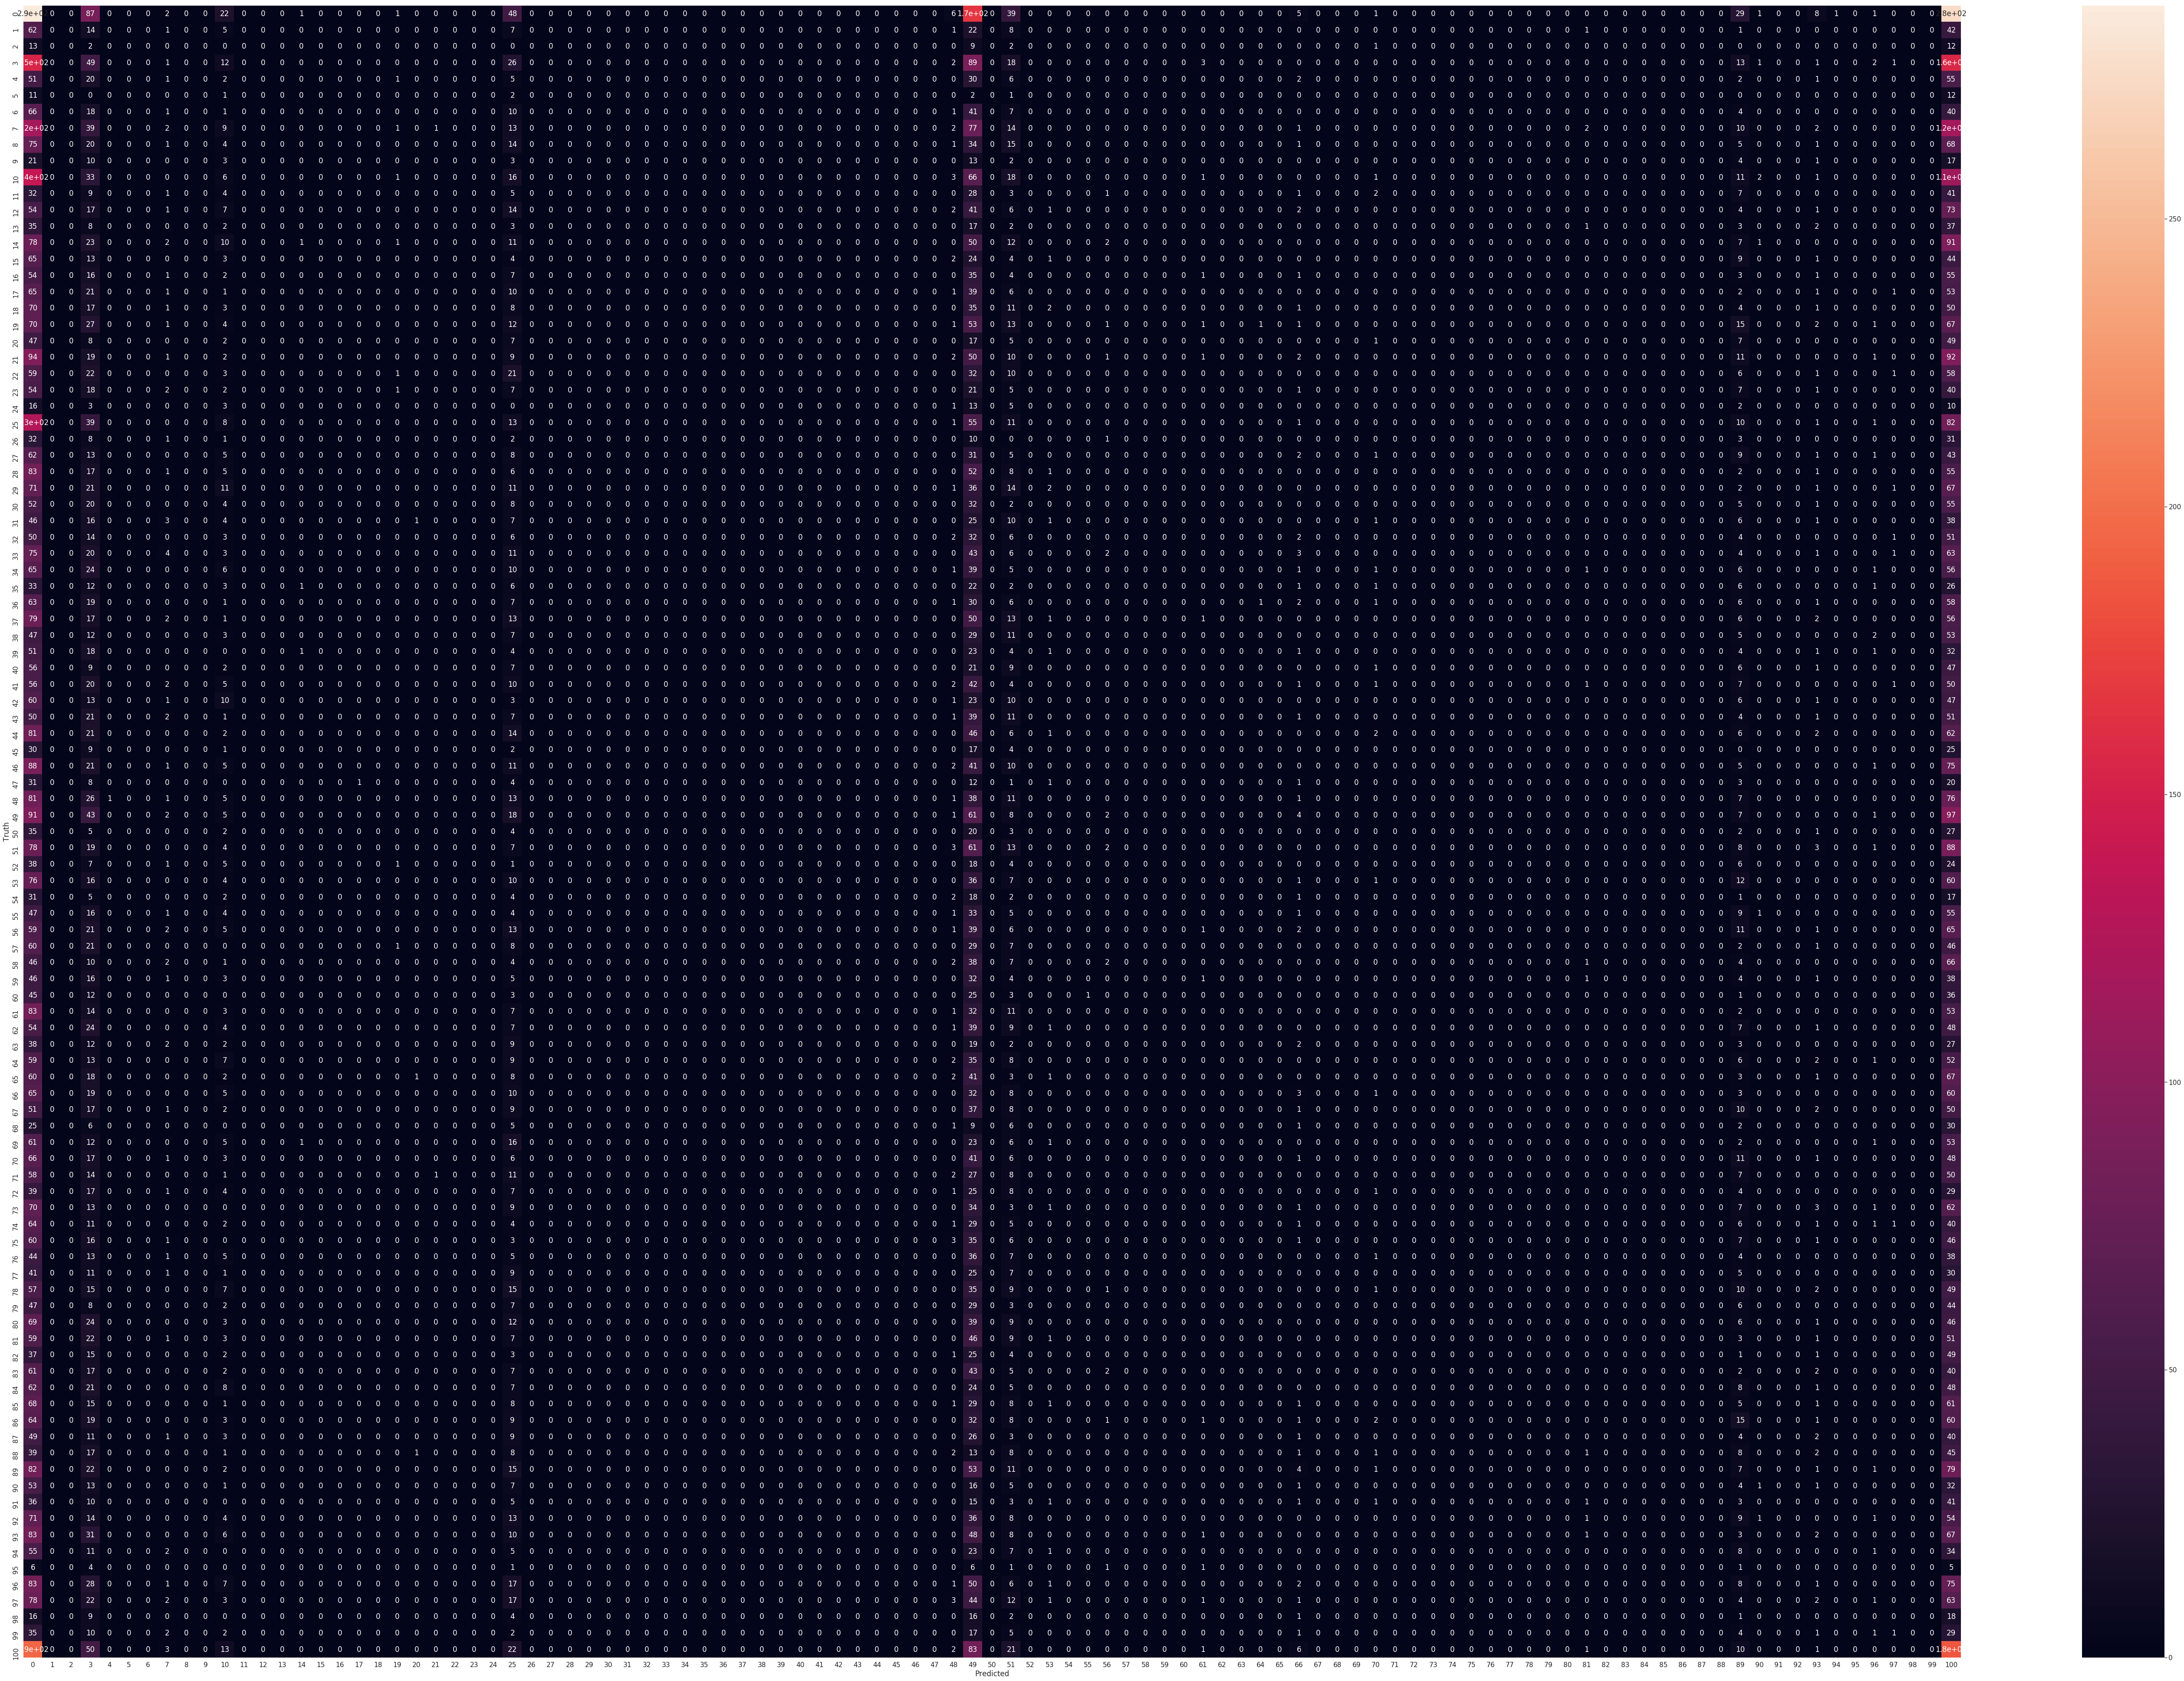

In [55]:
#STEP 1
#start of fraction section
#KNN

outcome = 'winPlacePerc'

features = ['kills','assists','damageDealt','heals','weaponsAcquired','winPoints','assists']
neighbors = 15

abbrev_trainset = trainset[:20000]
abbrev_valset = valset[:20000]


trainset_labels,valset_labels = bucket_labels(abbrev_trainset,abbrev_valset,100)

predictions = dict()
classifier = None 
for i in range(1,neighbors+1):
    print(i)
    classifier = KNeighborsClassifier(i)
    classifier.fit(abbrev_trainset[features], trainset_labels)
    predictions[i] = classifier.predict(abbrev_valset[features])

#Step 2 
#Logistic regression
multi_class_regression = LogisticRegression(solver='liblinear', multi_class='ovr').fit(abbrev_trainset[features],trainset_labels)
multi_class_predict = multi_class_regression.predict(abbrev_valset[features])
mea_log_reg = sklearn.metrics.mean_absolute_error(valset_labels, multi_class_predict)
print(mea_log_reg)
cm = confusion_matrix(valset_labels, multi_class_predict)
plt.figure(figsize = (100,70))
sn.heatmap(cm, annot=True)
sn.set(font_scale=1.4)
plt.xlabel("Predicted")
plt.ylabel("Truth")

#Step3 
#SVM RBF kernel
svm = SVC(decision_function_shape='ovo').fit(abbrev_trainset[features],trainset_labels)
svm_predictions = svm.predict(abbrev_valset[features])
mea_svm_predictions = sklearn.metrics.mean_absolute_error(valset_labels, svm_predictions)
print(mea_svm_predictions)
# cm_rbf = confusion_matrix(valset_labels, svm_predictions)
# plt.figure(figsize = (100,70))
# sn.heatmap(cm_rbf, annot=True)
# sn.set(font_scale=1.4)
# plt.xlabel("Predicted")
# plt.ylabel("Truth")

    

In [9]:

n_classes = max(valset_labels)
for i in range(1,neighbors):
    print(i,sklearn.metrics.mean_absolute_error(valset_labels,predictions[i]))
    

1 35.13655
2 34.8491
3 35.2624
4 36.1381
5 36.94885
6 37.55905
7 37.72045
8 38.32695
9 38.2839
10 38.349
11 38.4096
12 38.35515
13 38.11965
14 38.22735


In [10]:
#Forest of trees
features = ['year','age','genre1_num','gender_num']
trees = 10
rf = RandomForestClassifier(n_estimators=trees)
rf.fit(train[features],train['rating'])
predictions_FT = rf.predict(test[features])
# Calculate accuracy
numtrain = len(train)
numtest = len(test)
correct = 0
for i in range(numtest):
#    print 'Predicted:', predictions[i], ' Actual:', citiesTest.loc[numtrain+i]['category']
#    if predictions_FT[i] == test.loc[numtrain+i]['rating']: correct +=1
#print 'Accuracy:', float(correct)/float(numtest)
       
       
    print 'Predicted:', predictions_FT[i], ' Actual:', train.iloc[i]['rating']
    if predictions_FT[i] == test.iloc[i]['rating']: correct +=1
print 'Accuracy:', float(correct)/float(numtest)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Predicted:', predictions_FT[i], ' Actual:', train.iloc[i]['rating'])? (<ipython-input-10-6d58a5a68093>, line 17)

In [11]:
#Naive bayes
features = ['year','age','genre1_num','gender_num']
nb = GaussianNB()
nb.fit(train[features],train['rating'])
predictions_NB = nb.predict(test[features])
# Calculate accuracy
numtrain = len(train)
numtest = len(test)
correct = 0
for i in range(numtest):
    print('Predicted:', predictions_NB[i], ' Actual:', train.iloc[i]['rating'])
    if predictions_NB[i] == test.iloc[i]['rating']: correct +=1
print('Accuracy:', float(correct)/float(numtest))

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Predicted:', predictions_NB[i], ' Actual:', train.iloc[i]['rating'])? (<ipython-input-11-95d9c72086c3>, line 11)

In [15]:
#find mean
avgpredicts = []
for i in range(201):
    avgpredict=1.0*(predictions_KNN[i]+predictions_FT[i]+predictions_NB[i])/2
    avgpredicts.append(avgpredict)
for i, avgpredict in enumerate(avgpredicts):
    if avgpredict > 5: 
        avgpredicts[i] = 5.0
print(avgpredicts)

NameError: name 'predictions_KNN' is not defined

In [16]:
#STEP 3


#Exports real numbers predictions to csv - named V1predict.csv
import csv
input_file = csv.reader(open("predict.csv"))
# This is the file where you will save the result.
ofile = open('V1predict.csv', "w")
# This is a way to use csv.writer.
writer = csv.writer(ofile, quotechar='"', quoting=csv.QUOTE_ALL)
# loop over each row of predict.csv
for row_num, row in enumerate(input_file):
    # if header row, just write it and does nothing else
    if row_num == 0:
        writer.writerow(row)
        continue
    # if not header row, put your own prediction for the second column of the current row
    row[2] = str(avgpredicts[row_num-1])
    # write out the row to the file
    writer.writerow(row)
# finish writing to the file and close it
ofile.close()

FileNotFoundError: [Errno 2] No such file or directory: 'predict.csv'

In [14]:
#STEP 3


#Exports integers predictions to csv - named V2predict.csv

import csv
input_file = csv.reader(open("predict.csv"))
# This is the file where you will save the result.
ofile = open('V2predict.csv', "w")
# This is a way to use csv.writer.
writer = csv.writer(ofile, quotechar='"', quoting=csv.QUOTE_ALL)
# loop over each row of predict.csv
for row_num, row in enumerate(input_file):
    # if header row, just write it and does nothing else
    if row_num == 0:
        writer.writerow(row)
        continue
    # if not header row, put your own prediction for the second column of the current row
    row[2] = str(predictions[row_num-1])
    # write out the row to the file
    writer.writerow(row)
# finish writing to the file and close it
ofile.close()

FileNotFoundError: [Errno 2] No such file or directory: 'predict.csv'